# ADSP 31013: Big Data Platforms - Final Project
### Study on Chicago Taxi Tips Strategy and Crime correlation
<span style="color:maroon"><b> Team 5: Zach Farahany, Nancy Gu, David He</span>

<span style="color:maroon"><b> Nov 2023</span>


The Chicago Taxi Trips dataset is a comprehensive aggregation of taxi trips taken in the city of Chicago. The data, sourced from the <b>City of Chicago's public data</b> portal, encompasses a wide array of attributes ranging from timestamps for the start and end of each trip, geolocation coordinates for pickup and drop-off points, distances traveled, fare details, payment types, and taxi company information. <br><br>
Each record in the dataset is uniquely identified by a key, ensuring the traceability and integrity of the data. Spanning several years, the dataset provides an extensive chronological framework, allowing for in-depth temporal analysis and insights into travel patterns, economic factors influencing taxi usage, and the impact of events and policy changes on the taxi industry. <br><br>
The granularity of the dataset presents an excellent opportunity for exploratory data analysis (EDA), predictive modeling, and <b>the application of machine learning techniques to derive meaningful patterns and trends that could inform business decisions, urban planning, and transportation regulation in the context of Chicago's vibrant urban tapestry</b>.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, to_timestamp, split, dayofweek, year, lit, month, date_format, hour
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.mllib.stat import Statistics
from functools import reduce

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('FinalProject').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fad4827b-bf9c-43a1-bddd-d4b0adcb6097;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

## Read in Data Set

In [3]:
#Read in dataset from GCP
df = spark.read.parquet("gs://msca-bdp-student-gcs/chicago-taxi-trips-data/*.parquet",inferSchema=True)

## A. Data Exploration and Clean up

<font color='maroon'><b>1.Explore data columns<br>
<font color='maroon'><b>2.Cast data columns to the correct data types<br>
<font color='maroon'><b>3.Summarize data<br>
<font color='maroon'><b>4.Drop less useful columns<br>
<font color='maroon'><b>5.Explore null records and filter to not null values<br>
<font color='maroon'><b>6.Filter out outliers in key variables (trip time, fare, tips)<br>
<font color='maroon'><b>7.Get final record counts<br>
<font color='maroon'><b>8.Data engineering (extract year, month, day of week, trip minute info)<br>
<font color='maroon'><b>9.Append community names to pick up community area code<br>

In [5]:
#Explore dataset columns
df.columns

['unique_key',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_latitude',
 'pickup_longitude',
 'pickup_location',
 'dropoff_latitude',
 'dropoff_longitude',
 'dropoff_location']

In [4]:
# Cast the appropriate columns to the correct data types
df = df.withColumn("trip_start_timestamp", to_timestamp(col("trip_start_timestamp"), "yyyy-MM-ddHH:mm:ss")) \
       .withColumn("trip_end_timestamp", to_timestamp(col("trip_end_timestamp"), "yyyy-MM-ddHH:mm:ss")) \
       .withColumn("trip_seconds", col("trip_seconds").cast(IntegerType())) \
       .withColumn("trip_miles", col("trip_miles").cast(DoubleType())) \
       .withColumn("fare", col("fare").cast(DoubleType())) \
       .withColumn("tips", col("tips").cast(DoubleType())) \
       .withColumn("tolls", col("tolls").cast(DoubleType())) \
       .withColumn("extras", col("extras").cast(DoubleType())) \
       .withColumn("trip_total", col("trip_total").cast(DoubleType())) \
       .withColumn("pickup_latitude", col("pickup_latitude").cast(DoubleType())) \
       .withColumn("pickup_longitude", col("pickup_longitude").cast(DoubleType())) \
       .withColumn("dropoff_latitude", col("dropoff_latitude").cast(DoubleType())) \
       .withColumn("dropoff_longitude", col("dropoff_longitude").cast(DoubleType()))

In [6]:
df.printSchema()

root
 |-- unique_key: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- d

In [25]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+--------------------+------------------+-----------------+------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+--------------------+
|summary|          unique_key|             taxi_id|      trip_seconds|        trip_miles| pickup_census_tract|dropoff_census_tract|pickup_community_area|dropoff_community_area|              fare|              tips|               tolls|            extras|       trip_total|payment_type|             company|     pickup_latitude|   pickup_longitude|     pickup_location|    dropoff_latitude| dropoff_longitude|    dropoff_location|
+-------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+---------

In [5]:
#Drop columns after initial exploration
df = df.drop("trip_end_timestamp","pickup_census_tract","dropoff_census_tract","pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude","company","pickup_location","dropoff_location")

In [33]:
# Calculate null percentage for each column
total_rows = df.count()
null_percentage = df.select([
    (count(when(col(c).isNull(), c)) / total_rows * 100).alias(c) 
    for c in df.columns
])
null_percentage.show()

+----------+-------+--------------------+------------------+--------------------+---------------------+----------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+
|unique_key|taxi_id|trip_start_timestamp|      trip_seconds|          trip_miles|pickup_community_area|dropoff_community_area|                fare|                tips|             tolls|              extras|          trip_total|payment_type|
+----------+-------+--------------------+------------------+--------------------+---------------------+----------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------+
|       0.0|    0.0|                 0.0|0.6181936492485639|0.001374709885659...|    11.46370193897228|     13.53786336000837|0.008838776958210386|0.008838776958210386|15.620437284011881|0.008838776958210386|0.008838776958210386|         0.0|
+----------+-------+--------

In [6]:
# Filter out records where all fields are not null
non_null_df = df.filter(~reduce(lambda a, b: a | b, (col(x).isNull() for x in df.columns)))

In [34]:
total_useful_rows = non_null_df.count()
print("Original dataset record counts: ",total_rows)
print("Not-null record counts: ",total_useful_rows)

Original dataset record count:  210662630


Not-null record count:  150854305


In [7]:
# Define a function to calculate the bounds for outliers
def get_outlier_bounds(df, col_name):
    # Calculate Q1 and Q3 and subsequently the IQR
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)  # 0.05 is the relative error
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

# Get outlier bounds for trip_seconds, fare, and tips
trip_seconds_bounds = get_outlier_bounds(non_null_df, "trip_seconds")
fare_bounds = get_outlier_bounds(non_null_df, "fare")
tips_bounds = get_outlier_bounds(non_null_df, "tips")

# Filter the DataFrame to exclude outliers
filtered_df = non_null_df.filter(
    (col("trip_seconds").between(lit(trip_seconds_bounds[0]), lit(trip_seconds_bounds[1]))) &
    (col("fare").between(lit(fare_bounds[0]), lit(fare_bounds[1]))) &
    (col("tips").between(lit(tips_bounds[0]), lit(tips_bounds[1])))
)

In [9]:
# Count the remaining records to verify the filter operation
record_count = filtered_df.count()

print("Number of records after filtering outliers:", record_count)

Number of records after filtering outliers: 127445685


In [8]:
# Calculate trip_minute from trip_seconds, year & day of the week from trip_start_timestamp, 
filtered_df = filtered_df.withColumn("trip_minute", (col("trip_seconds") / 60).cast(DoubleType())) \
                         .withColumn("trip_year", year(col("trip_start_timestamp"))) \
                         .withColumn("trip_month", month(col("trip_start_timestamp"))) \
                         .withColumn("trip_dayofweek", dayofweek(col("trip_start_timestamp")))

In [9]:
#Add community name (from metadata) to the dataset
community_names_schema = ["pickup_community_area", "pickup_community_area_name"]
community_names_data = [
    (1, "Rogers Park"),
    (2, "West Ridge"),
    (3, "Uptown"),
    (4, "Lincoln Square"),
    (5, "North Center"),
    (6, "Lake View"),
    (7, "Lincoln Park"),
    (8, "Near North Side"),
    (9, "Edison Park"),
    (10, "Norwood Park"),
    (11, "Jefferson Park"),
    (12, "Forest Glen"),
    (13, "North Park"),
    (14, "Albany Park"),
    (15, "Portage Park"),
    (16, "Irving Park"),
    (17, "Dunning"),
    (18, "Montclare"),
    (19, "Belmont Cragin"),
    (20, "Hermosa"),
    (21, "Avondale"),
    (22, "Logan Square"),
    (23, "Humboldt Park"),
    (24, "West Town"),
    (25, "Austin"),
    (26, "West Garfield Park"),
    (27, "East Garfield Park"),
    (28, "Near West Side"),
    (29, "North Lawndale"),
    (30, "South Lawndale"),
    (31, "Lower West Side"),
    (32, "(The) Loop"),
    (33, "Near South Side"),
    (34, "Armour Square"),
    (35, "Douglas"),
    (36, "Oakland"),
    (37, "Fuller Park"),
    (38, "Grand Boulevard"),
    (39, "Kenwood"),
    (40, "Washington Park"),
    (41, "Hyde Park"),
    (42, "Woodlawn"),
    (43, "South Shore"),
    (44, "Chatham"),
    (45, "Avalon Park"),
    (46, "South Chicago"),
    (47, "Burnside"),
    (48, "Calumet Heights"),
    (49, "Roseland"),
    (50, "Pullman"),
    (51, "South Deering"),
    (52, "East Side"),
    (53, "West Pullman"),
    (54, "Riverdale"),
    (55, "Hegewisch"),
    (56, "Garfield Ridge"),
    (57, "Archer Heights"),
    (58, "Brighton Park"),
    (59, "McKinley Park"),
    (60, "Bridgeport"),
    (61, "New City"),
    (62, "West Elsdon"),
    (63, "Gage Park"),
    (64, "Clearing"),
    (65, "West Lawn"),
    (66, "Chicago Lawn"),
    (67, "West Englewood"),
    (68, "Englewood"),
    (69, "Greater Grand Crossing"),
    (70, "Ashburn"),
    (71, "Auburn Gresham"),
    (72, "Beverly"),
    (73, "Washington Heights"),
    (74, "Mount Greenwood"),
    (75, "Morgan Park"),
    (76, "O'Hare"),
    (77, "Edgewater")
]

community_names_df = spark.createDataFrame(community_names_data, schema=community_names_schema)

filtered_df = filtered_df.join(community_names_df, "pickup_community_area", "left")

In [43]:
filtered_df.show(3)

+---------------------+--------------------+--------------------+--------------------+------------+----------+----------------------+----+----+-----+------+----------+------------+-----------+---------+--------------+--------------------------+
|pickup_community_area|          unique_key|             taxi_id|trip_start_timestamp|trip_seconds|trip_miles|dropoff_community_area|fare|tips|tolls|extras|trip_total|payment_type|trip_minute|trip_year|trip_dayofweek|pickup_community_area_name|
+---------------------+--------------------+--------------------+--------------------+------------+----------+----------------------+----+----+-----+------+----------+------------+-----------+---------+--------------+--------------------------+
|                   29|9411ddaee7c49a3b3...|d738f89082c4e00e9...| 2017-09-16 23:00:00|        1260|       0.0|                    22|17.0| 0.0|  0.0|   1.0|      18.0|        Cash|       21.0|     2017|             7|            North Lawndale|
|                   

### Exploratory Data Analysis

<font color='maroon'><b>1. Bar plot of Trip count by year-month<br>
<font color='maroon'><b>2. Heatmap of Trips by Pickup Community Area and Hour of Day<br>
<font color='maroon'><b>3. Bar plot of Trips by Community Area<br>
<font color='maroon'><b>4. Average Tips for Each Trip by Month<br>

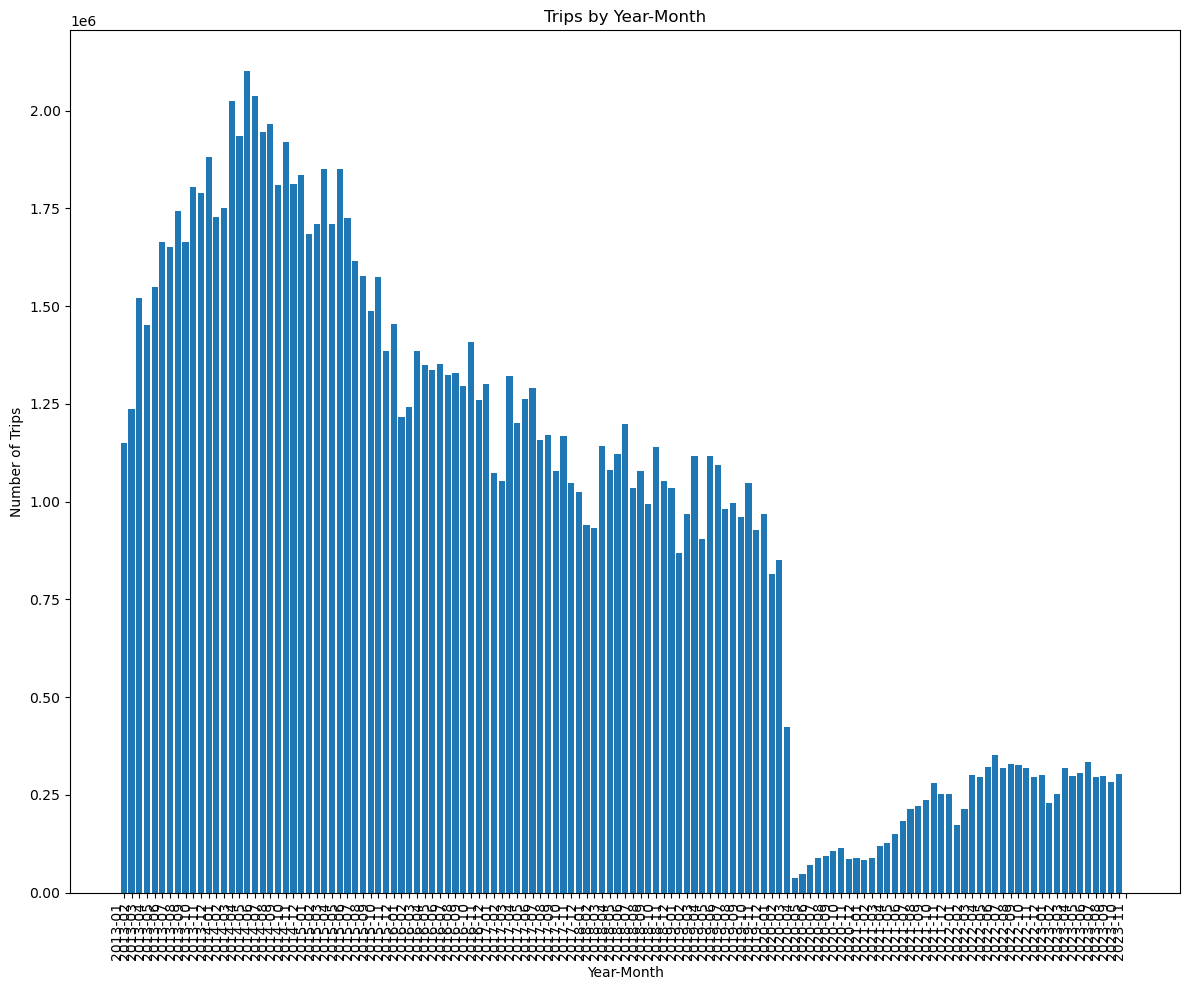

In [19]:
# Aggregate trip count by year-month
trips_by_year_month = filtered_df.groupBy(
    year("trip_start_timestamp").alias("Year"), 
    month("trip_start_timestamp").alias("Month")
).count().orderBy("Year", "Month")

trips_by_year_month_data = trips_by_year_month.collect()

# Plotting
plt.figure(figsize=(12,10))
plt.bar([f'{x["Year"]}-{x["Month"]:02d}' for x in trips_by_year_month_data], [x["count"] for x in trips_by_year_month_data])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Year-Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=90)
plt.title('Trips by Year-Month')
plt.tight_layout()
plt.show()

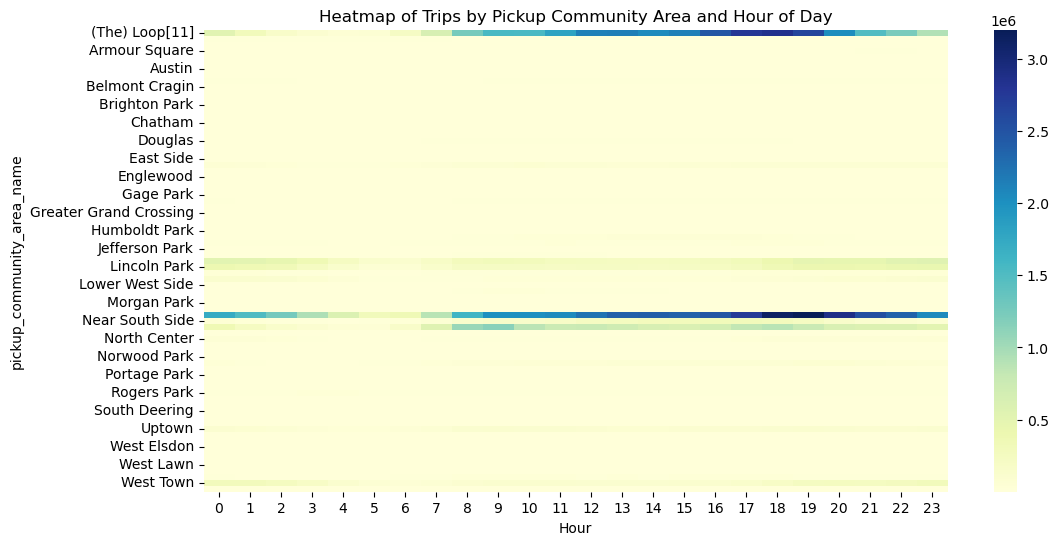

In [11]:
# Aggregate trip count by pickup community area and hour of day
trips_heatmap_data = filtered_df.groupBy(
    "pickup_community_area_name", 
    hour("trip_start_timestamp").alias("Hour")
).count().orderBy("pickup_community_area_name", "Hour").toPandas()

# Create a pivot table for the heatmap
pivot_table = pd.pivot_table(
    trips_heatmap_data, 
    values='count', 
    index='pickup_community_area_name', 
    columns='Hour', 
    aggfunc=np.sum
)

# Plotting
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu")
plt.title('Heatmap of Trips by Pickup Community Area and Hour of Day')
plt.show()

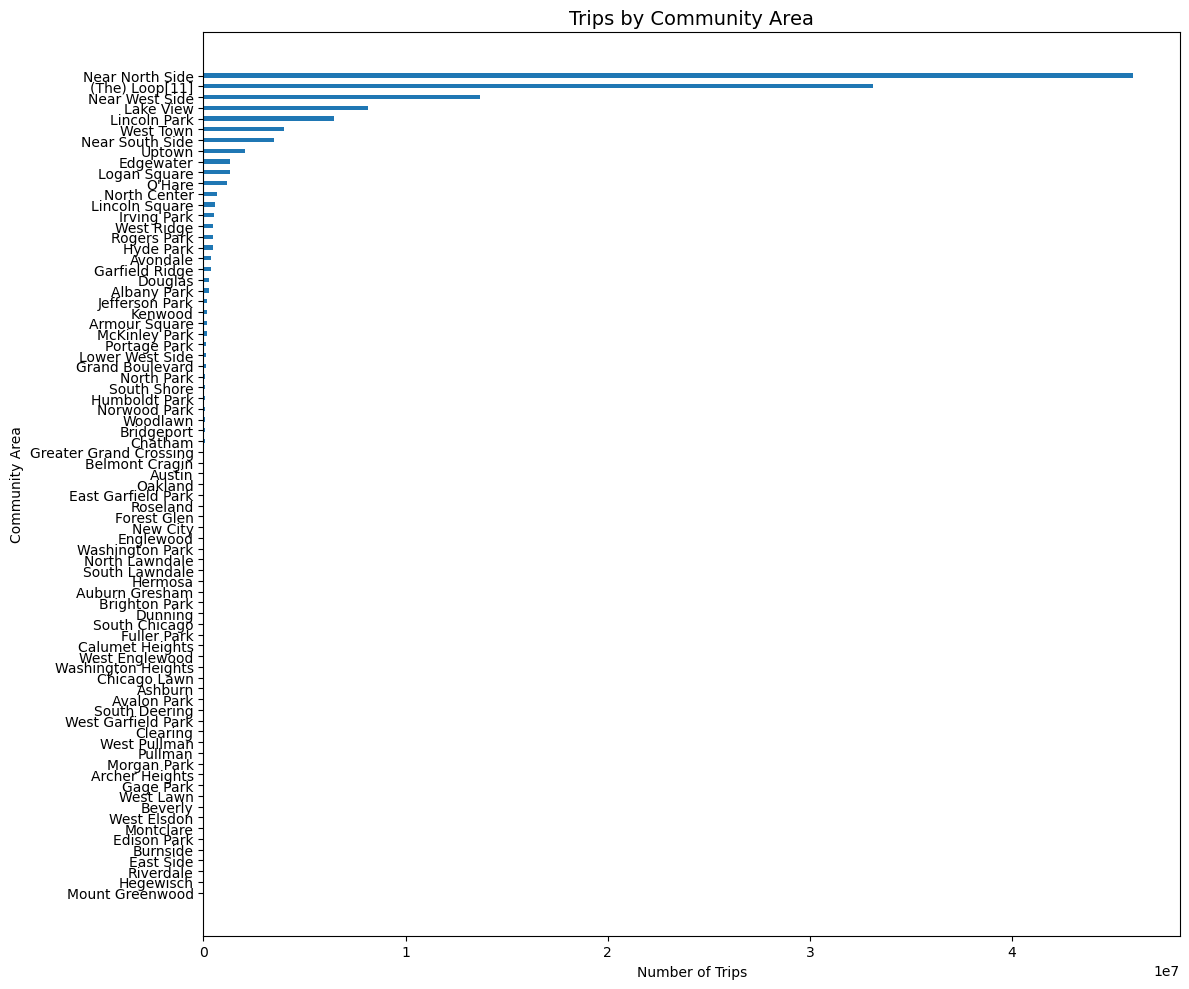

In [17]:
# Aggregate trip count by community area
trips_by_community = filtered_df.groupBy("pickup_community_area_name").count().orderBy("count", ascending=False).toPandas()

# Plotting
plt.figure(figsize=(12, 10))
plt.barh(y=range(len(trips_by_community['pickup_community_area_name'])), width=trips_by_community['count'], height=0.4)
plt.yticks(ticks=range(len(trips_by_community['pickup_community_area_name'])), labels=trips_by_community['pickup_community_area_name'])

plt.xlabel('Number of Trips')
plt.ylabel('Community Area')
plt.title('Trips by Community Area', fontsize=14)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

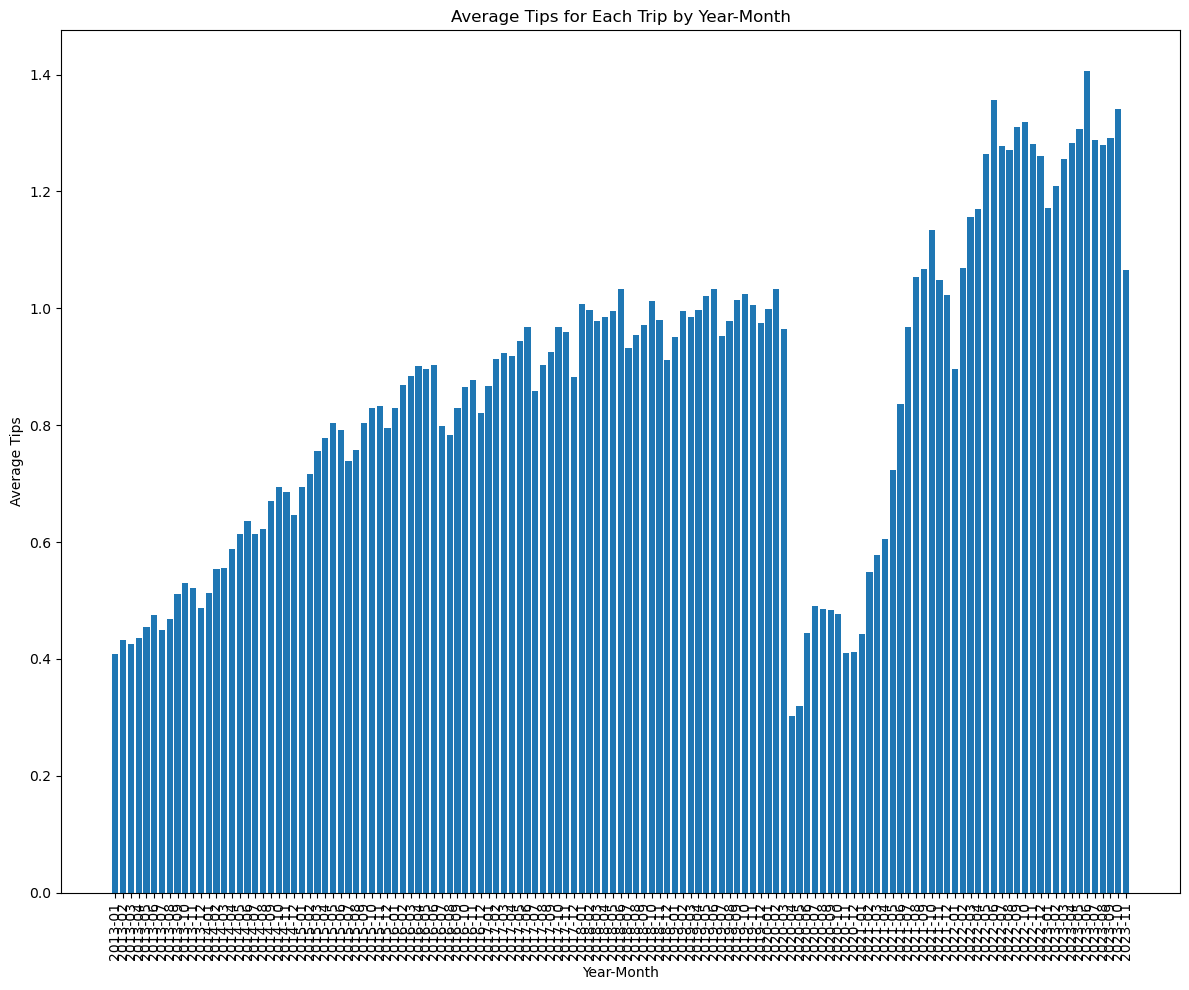

In [20]:
# Aggregate average tips by month
avg_tips_by_month = filtered_df.groupBy(year("trip_start_timestamp").alias("Year"), 
    month("trip_start_timestamp").alias("Month")).avg("tips").orderBy("Year","Month")

avg_tips_by_month_data = avg_tips_by_month.collect()

# Plotting
plt.figure(figsize=(12, 10))
plt.bar([f'{x["Year"]}-{x["Month"]:02d}' for x in avg_tips_by_month_data], [x["avg(tips)"] for x in avg_tips_by_month_data])
plt.xlabel('Year-Month')
plt.ylabel('Average Tips')
plt.xticks(rotation=90)
plt.title('Average Tips for Each Trip by Year-Month')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate correlation matrix
numerical_cols = ["trip_seconds", "trip_miles", "fare", "tips", "tolls", "extras", "trip_total"]
df_numerical = df.select(numerical_cols).toPandas()

# Plotting
fig = plt.figure(figsize = (15, 10));
ax = fig.gca();
df_numerical.hist(ax = ax, color = 'maroon')